# Predictions of the likelihood of EPEs for Wellington region with 4 climate variables (including precipitation)
This notebook holds the modelling of EPEs for Wellington region with ERA5 reanalysis data for 4 climate variables temp,
surface pressure, total column water and precipitation.

# Importing Libraries

In [59]:
# importing libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import xlrd
import seaborn as sns
import imblearn

from imblearn.combine import SMOTETomek
from xgboost.sklearn import XGBClassifier
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, accuracy_score, roc_auc_score

In [3]:
import sklearn
print('sklearn version {}'.format(sklearn.__version__))

sklearn version 0.24.0


# Reading Data

In [2]:
# Function to read array dataset and convert it into dataframe

def get_data(file):
    # path of different variables data for Wellington region 
    file_path = '/mnt/temp/Projects/Emergence/Data_Keep/epe/ERA5_1d/' + file + '/average/Wellington_1d.nc'
    # Reading array dataset
    df = xr.open_dataset(file_path)
    # Converting array dataset into dataframe
    data = df.to_dataframe()
    
    return data
   

In [3]:
# To get temperature data and change it's column name to 'temp' 
data_t = get_data('2T')
df_t = data_t.rename(columns={'data':'temp'})
df_t

,temp
time,
1996-01-01 00:00:00,290.853851
1996-01-01 01:00:00,291.417694
1996-01-01 02:00:00,292.178162
1996-01-01 03:00:00,292.575165
1996-01-01 04:00:00,292.863342
...,...
2020-04-30 19:00:00,285.855133
2020-04-30 20:00:00,287.536957
2020-04-30 21:00:00,287.438690


In [4]:
# To get surface pressure data and change it's column name to 'sp' 
data_s = get_data('SP')
df_sp = data_s.rename(columns={'data':'sp'})

# To get total column water data and change it's column name to 'tcw'
data_w = get_data('TCW')
df_tcw = data_w.rename(columns={'data':'tcw'})

# To get total percipitation
data_prec = get_data('total_precipitation')
df_prec = data_prec.rename(columns={'data':'precip'})

In [7]:
df_prec.isna()

,precip
time,
1996-01-01 00:00:00,False
1996-01-01 01:00:00,False
1996-01-01 02:00:00,False
1996-01-01 03:00:00,False
1996-01-01 04:00:00,False
...,...
2019-09-01 02:00:00,False
2019-09-01 03:00:00,False
2019-09-01 04:00:00,False


In [5]:
# combine 4 dataframes
frames = [df_t, df_sp, df_tcw, df_prec]
new_data = pd.concat(frames, axis=1, sort=False)
new_data

,temp,sp,tcw,precip
time,,,,
1996-01-01 00:00:00,290.853851,100175.007812,16.728743,0.000013
1996-01-01 01:00:00,291.417694,100133.265625,17.180902,0.000040
1996-01-01 02:00:00,292.178162,100123.757812,17.231808,0.000079
1996-01-01 03:00:00,292.575165,100070.734375,16.735910,0.000047
1996-01-01 04:00:00,292.863342,100008.296875,16.049551,0.000032
...,...,...,...,...
2020-04-30 19:00:00,285.855133,99768.148438,7.431450,NaN
2020-04-30 20:00:00,287.536957,99792.570312,7.424390,NaN
2020-04-30 21:00:00,287.438690,99826.421875,7.393387,NaN


## Era5 DataFrames

In [6]:
# dropping nan values
main_data = new_data.dropna()
main_data

,temp,sp,tcw,precip
time,,,,
1996-01-01 00:00:00,290.853851,100175.007812,16.728743,1.259973e-05
1996-01-01 01:00:00,291.417694,100133.265625,17.180902,4.038088e-05
1996-01-01 02:00:00,292.178162,100123.757812,17.231808,7.908612e-05
1996-01-01 03:00:00,292.575165,100070.734375,16.735910,4.740612e-05
1996-01-01 04:00:00,292.863342,100008.296875,16.049551,3.169816e-05
...,...,...,...,...
2019-09-01 02:00:00,286.357513,99763.289062,8.832370,2.053400e-07
2019-09-01 03:00:00,286.169037,99742.523438,8.599445,7.039801e-08
2019-09-01 04:00:00,286.095978,99699.265625,8.403327,0.000000e+00


## Extreme events dataframe

In [13]:
# Reading maximum events
Extrm_data = pd.read_excel('/mnt/storage/Scratch/Fareeda/historical_ewes_tagged_202004241455_eventtiming.xlsx')
Extrm_data

ParserError: Expected 28 fields in line 258, saw 29

In [14]:
# Reading extreme events data
Extrm_data = pd.read_csv('/mnt/storage/Scratch/Fareeda/historical_ewes_tagged_202004241455_eventtiming.csv')
Extrm_data

,Event date,Event Title,Source,Nld,Ald,Wko,Bop,Gsb,Hby,Tki,...,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37
0,1996-03-31,March 1996 Eastern North Island Ex-Tropical Cy...,NIWA,NaN,NaN,NaN,NaN,3R,3R;3W,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1996-07-01,July 1996 South Island Snowfall,NIWA,NaN,NaN,NaN,NaN,NaN,1S,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1996-07-11,July 1996 Northland Auckland Rainfall,MetService,3R,3R,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1996-07-14,July 1996 Waikato Flooding,NIWA,NaN,NaN,3R,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1996-08-01,August 1996 Northland Coromandel Rainfall,MetService,3R,NaN,3R,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,2019-12-03,December 2019 South Island Heavy Rain 1,MetService,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
837,2019-12-08,December 2019 South Island Heavy Rain 2,MetService,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
838,2019-12-16,December 2019 Waikato Convection,MetService,NaN,NaN,3C,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
839,2019-12-17,December 2019 Northern South Island Heavy Rain,MetService,NaN,3C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Extracting 4 columns (Wellington, event start, event end and duration of events) from sheat dataframe
extm = Extrm_data[[ 'Wgn', 'Event Start', 'Event End', 'Event Duration']]
extm

,Wgn,Event Start,Event End,Event Duration
0,NaN,1996-03-29T21:00Z,1996-03-31T21:00Z,48
1,NaN,NaN,NaN,NaN
2,NaN,1996-07-09T21:00Z,1996-07-14T00:00Z,99
3,NaN,1996-07-13T21:00Z,1996-07-16T22:00Z,73
4,NaN,1996-07-30T21:00Z,1996-08-02T21:00Z,72
...,...,...,...,...
836,NaN,2019-11-30T22:00Z,2019-12-05T22:00Z,120
837,2R,2019-12-04T21:00Z,2019-12-08T20:00Z,95
838,NaN,NaN,NaN,NaN
839,NaN,2019-12-15T10:00Z,2019-12-19T18:00Z,104


In [17]:
# Removing null rows
extm1 = extm.dropna()
extm1

,Wgn,Event Start,Event End,Event Duration
8,3W,1996-09-30T19:00Z,1996-10-01T21:00Z,26
9,3R;3W,1996-10-11T18:00Z,1996-10-13T20:00Z,50
27,3R,1997-06-16T16:00Z,1997-06-18T03:00Z,35
35,2R;3W,1997-09-30T00:00Z,1997-10-05T20:00Z,140
49,3R,1998-02-23T17:00Z,1998-02-23T23:00Z,6
...,...,...,...,...
778,3W,2018-02-18T20:00Z,2018-02-21T20:00Z,72
791,2R,2018-06-10T20:00Z,2018-06-13T21:00Z,73
794,3R;3W,2018-07-06T13:00Z,2018-07-09T05:00Z,64
814,3R,2019-03-07T16:00Z,2019-03-08T23:00Z,31


In [18]:
# Selecting rows that has R in Wgn column because we are interested in precipitation
extm_R = extm1.loc[extm1['Wgn'].str.contains('R')]
extm_R

,Wgn,Event Start,Event End,Event Duration
9,3R;3W,1996-10-11T18:00Z,1996-10-13T20:00Z,50
27,3R,1997-06-16T16:00Z,1997-06-18T03:00Z,35
35,2R;3W,1997-09-30T00:00Z,1997-10-05T20:00Z,140
49,3R,1998-02-23T17:00Z,1998-02-23T23:00Z,6
53,3W;3R,1998-03-27T21:00Z,1998-03-30T21:00Z,72
...,...,...,...,...
773,3R;3W,2018-01-30T20:00Z,2018-02-03T02:00Z,78
791,2R,2018-06-10T20:00Z,2018-06-13T21:00Z,73
794,3R;3W,2018-07-06T13:00Z,2018-07-09T05:00Z,64
814,3R,2019-03-07T16:00Z,2019-03-08T23:00Z,31


In [21]:
# Changing date format 
import datetime
d1 = datetime.datetime.strptime("1996-10-11T18:00Z","%Y-%m-%dT%H:%SZ")

new_format = "%Y-%m-%d"
d1.strftime(new_format)



'1996-10-11'

In [23]:
for date in sh3['Event End']:
    d2 = datetime.datetime.strptime(date,"%Y-%m-%dT%H:%SZ")
    
    d2.strftime(new_format)
   # print(date)
    

ValueError: time data 'one in Te Horo Beach Rd and another near the Mangaone Stream.\\""' does not match format '%Y-%m-%dT%H:%SZ'

Errors represent that all the enries of event start and event end are not in date format

In [19]:
# Checking date format 

for date in extm_R['Event End']:
#     d2 = datetime.datetime.strptime(date,"%Y-%m-%dT%H:%SZ")
    
#     d2.strftime(new_format)
    print(date)
    
    
    

1996-10-13T20:00Z
1997-06-18T03:00Z
1997-10-05T20:00Z
1998-02-23T23:00Z
1998-03-30T21:00Z
1998-06-14T01:00Z
1998-06-26T21:00Z
1998-07-02T21:00Z
1998-10-12T20:00Z
1998-10-20T20:00Z
1998-10-29T05:00Z
1999-03-23T21:00Z
1999-08-21T21:00Z
1999-11-12T20:00Z
1999-11-29T20:00Z
1999-12-19T20:00Z
2000-10-02T00:00Z
2000-10-02T21:00Z
2000-10-11T20:00Z
2001-11-23T20:00Z
2003-06-09T21:00Z
2003-10-03T23:00Z
2004-01-21T20:00Z
2004-02-01T21:00Z
2004-02-13T19:00Z
2004-02-16T20:00Z
2004-02-28T22:00Z
2004-04-06T23:00Z
2004-06-21T21:00Z
2005-01-08T00:00Z
2005-03-31T14:00Z
2005-07-14T21:00Z
2006-06-19T23:00Z
2006-07-06T21:00Z
2006-07-20T21:00Z
2006-08-26T21:00Z
2006-10-24T00:00Z
2006-11-17T23:00Z
2007-10-09T01:00Z
one in Te Horo Beach Rd and another near the Mangaone Stream.\""
2008-03-02T20:00Z
2008-07-12T21:00Z
2008-07-31T21:00Z
2008-08-15T21:00Z
2008-08-26T21:00Z
2008-10-08T13:00Z
2009-02-21T20:00Z
2009-07-23T22:00Z
2010-01-16T20:00Z
2010-01-24T18:00Z
2010-05-26T21:00Z
2011-01-24T00:00Z
2012-03-03T20:00Z

In [ ]:
pat = r'^[0-9]'
sh3['Event End'].str.contains('^[0-9]')

In [20]:
# Selecting rows of event start column that starts with 0-9 to have the rows whose entries are in proper date format
extm2 = extm_R.loc[extm_R['Event Start'].str.contains('^[0-9]')]
extm2

,Wgn,Event Start,Event End,Event Duration
9,3R;3W,1996-10-11T18:00Z,1996-10-13T20:00Z,50
27,3R,1997-06-16T16:00Z,1997-06-18T03:00Z,35
35,2R;3W,1997-09-30T00:00Z,1997-10-05T20:00Z,140
49,3R,1998-02-23T17:00Z,1998-02-23T23:00Z,6
53,3W;3R,1998-03-27T21:00Z,1998-03-30T21:00Z,72
...,...,...,...,...
773,3R;3W,2018-01-30T20:00Z,2018-02-03T02:00Z,78
791,2R,2018-06-10T20:00Z,2018-06-13T21:00Z,73
794,3R;3W,2018-07-06T13:00Z,2018-07-09T05:00Z,64
814,3R,2019-03-07T16:00Z,2019-03-08T23:00Z,31


In [21]:
main_data

,temp,sp,tcw,precip
time,,,,
1996-01-01 00:00:00,290.853851,100175.007812,16.728743,1.259973e-05
1996-01-01 01:00:00,291.417694,100133.265625,17.180902,4.038088e-05
1996-01-01 02:00:00,292.178162,100123.757812,17.231808,7.908612e-05
1996-01-01 03:00:00,292.575165,100070.734375,16.735910,4.740612e-05
1996-01-01 04:00:00,292.863342,100008.296875,16.049551,3.169816e-05
...,...,...,...,...
2019-09-01 02:00:00,286.357513,99763.289062,8.832370,2.053400e-07
2019-09-01 03:00:00,286.169037,99742.523438,8.599445,7.039801e-08
2019-09-01 04:00:00,286.095978,99699.265625,8.403327,0.000000e+00


In [22]:
# Function to convert date format
new_format1 = "%Y-%m-%d %H:%S:00"

import datetime
def convertDate(d):
     new_date = datetime.datetime.strptime(d,"%Y-%m-%dT%H:%SZ")
     #return new_date.date()
     return new_date.strftime(new_format1)
convertDate("2018-07-09T05:00Z")

'2018-07-09 05:00:00'

In [23]:
# changing date format of event start and event end columns using apply function

extm2['Event_Start'] = extm2['Event Start'].apply(convertDate)
extm2['Event_End'] = extm2['Event End'].apply(convertDate)
extm2['Event_duration'] = extm2['Event Duration']
extm2

<ipython-input-23-e0fb1195607c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extm2['Event_Start'] = extm2['Event Start'].apply(convertDate)
<ipython-input-23-e0fb1195607c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extm2['Event_End'] = extm2['Event End'].apply(convertDate)
<ipython-input-23-e0fb1195607c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

,Wgn,Event Start,Event End,Event Duration,Event_Start,Event_End,Event_duration
9,3R;3W,1996-10-11T18:00Z,1996-10-13T20:00Z,50,1996-10-11 18:00:00,1996-10-13 20:00:00,50
27,3R,1997-06-16T16:00Z,1997-06-18T03:00Z,35,1997-06-16 16:00:00,1997-06-18 03:00:00,35
35,2R;3W,1997-09-30T00:00Z,1997-10-05T20:00Z,140,1997-09-30 00:00:00,1997-10-05 20:00:00,140
49,3R,1998-02-23T17:00Z,1998-02-23T23:00Z,6,1998-02-23 17:00:00,1998-02-23 23:00:00,6
53,3W;3R,1998-03-27T21:00Z,1998-03-30T21:00Z,72,1998-03-27 21:00:00,1998-03-30 21:00:00,72
...,...,...,...,...,...,...,...
773,3R;3W,2018-01-30T20:00Z,2018-02-03T02:00Z,78,2018-01-30 20:00:00,2018-02-03 02:00:00,78
791,2R,2018-06-10T20:00Z,2018-06-13T21:00Z,73,2018-06-10 20:00:00,2018-06-13 21:00:00,73
794,3R;3W,2018-07-06T13:00Z,2018-07-09T05:00Z,64,2018-07-06 13:00:00,2018-07-09 05:00:00,64
814,3R,2019-03-07T16:00Z,2019-03-08T23:00Z,31,2019-03-07 16:00:00,2019-03-08 23:00:00,31


In [24]:
# Dropping columns of dates of older version
extm2.drop(['Event Start', 'Event End', 'Event Duration'], axis=1, inplace=True)
extm2

/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Wgn,Event_Start,Event_End,Event_duration
9,3R;3W,1996-10-11 18:00:00,1996-10-13 20:00:00,50
27,3R,1997-06-16 16:00:00,1997-06-18 03:00:00,35
35,2R;3W,1997-09-30 00:00:00,1997-10-05 20:00:00,140
49,3R,1998-02-23 17:00:00,1998-02-23 23:00:00,6
53,3W;3R,1998-03-27 21:00:00,1998-03-30 21:00:00,72
...,...,...,...,...
773,3R;3W,2018-01-30 20:00:00,2018-02-03 02:00:00,78
791,2R,2018-06-10 20:00:00,2018-06-13 21:00:00,73
794,3R;3W,2018-07-06 13:00:00,2018-07-09 05:00:00,64
814,3R,2019-03-07 16:00:00,2019-03-08 23:00:00,31


In [285]:
main_data.isna()

,temp,sp,tcw,precip
time,,,,
1996-01-01 00:00:00,False,False,False,False
1996-01-01 01:00:00,False,False,False,False
1996-01-01 02:00:00,False,False,False,False
1996-01-01 03:00:00,False,False,False,False
1996-01-01 04:00:00,False,False,False,False
...,...,...,...,...
2019-09-01 02:00:00,False,False,False,False
2019-09-01 03:00:00,False,False,False,False
2019-09-01 04:00:00,False,False,False,False


In [25]:
# Function to select rows from main data dataframe that lie between event start and end event columns of sh5 dataframe then calculate max, min amd mean of temp, sp, tcw and 
# precip variables of main data dataframe

def mask1(d):
    
    rows = main_data.loc[(main_data.index >= d.Event_Start) & (main_data.index <= d.Event_End)]
    d['temp_max'] = rows.temp.max()
    d['temp_max'] = rows.temp.max()
    d['temp_min'] = rows.temp.min()
    d['temp_mean'] = rows.temp.mean()
    d['sp_max'] = rows.sp.max()
    d['sp_min'] = rows.sp.min()
    d[ 'sp_mean'] = rows.sp.mean()
    d['tcw_max'] = rows.tcw.max()
    d['tcw_min'] = rows.tcw.min()
    d[ 'tcw_mean'] = rows.tcw.mean()
    d['precip_max'] = rows.precip.max()
    d[ 'precip_min'] = rows.precip.min()
    d[ 'precip_mean'] = rows.precip.mean()
        
    return d 

In [26]:
# Dataframe 

extm_var = extm2.apply(mask1, axis=1)
extm_var

,Wgn,Event_Start,Event_End,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,precip_max,precip_min,precip_mean
9,3R;3W,1996-10-11 18:00:00,1996-10-13 20:00:00,50,288.618622,282.704926,286.294952,97805.625000,96094.367188,97054.914062,35.010063,13.019938,21.753832,0.002135,0.000014,0.000395
27,3R,1997-06-16 16:00:00,1997-06-18 03:00:00,35,285.822144,279.809784,283.655914,99098.367188,97454.796875,98313.453125,27.280825,16.356844,21.907808,0.002465,0.000039,0.000800
35,2R;3W,1997-09-30 00:00:00,1997-10-05 20:00:00,140,287.890137,278.181488,283.411652,99210.210938,97215.984375,98005.500000,26.705261,7.335347,16.051527,0.003848,0.000000,0.000564
49,3R,1998-02-23 17:00:00,1998-02-23 23:00:00,6,286.573242,285.419495,285.962830,97362.164062,97165.492188,97266.078125,29.321499,23.222336,26.541691,0.003299,0.001705,0.002382
53,3W;3R,1998-03-27 21:00:00,1998-03-30 21:00:00,72,294.711884,285.905548,289.933289,99743.312500,97501.062500,98391.445312,34.449261,7.907701,19.024771,0.001193,0.000000,0.000114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,3R;3W,2018-01-30 20:00:00,2018-02-03 02:00:00,78,298.440948,286.338928,292.088409,98827.835938,96703.046875,97609.562500,42.292416,12.697303,23.392792,0.001163,0.000000,0.000152
791,2R,2018-06-10 20:00:00,2018-06-13 21:00:00,73,286.613434,282.649567,285.050751,99729.414062,97756.929688,98599.742188,24.775269,12.002686,20.999605,0.002251,0.000003,0.000451
794,3R;3W,2018-07-06 13:00:00,2018-07-09 05:00:00,64,287.612366,281.020782,284.966187,98885.164062,96459.312500,97622.101562,26.536886,12.414055,19.786707,0.002594,0.000006,0.000607
814,3R,2019-03-07 16:00:00,2019-03-08 23:00:00,31,291.316040,286.588837,289.237793,99303.921875,98979.812500,99130.015625,35.256756,17.349186,29.034767,0.002679,0.000080,0.000847


In [311]:
main_data.loc[(main_data.index >= sh5.Event_Start[837])& (main_data.index <= sh5.Event_End[837])]

,temp,sp,tcw,precip
time,,,,


In [27]:
# Drop nan values
extm_var.dropna(inplace=True)
extm_var

,Wgn,Event_Start,Event_End,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,precip_max,precip_min,precip_mean
9,3R;3W,1996-10-11 18:00:00,1996-10-13 20:00:00,50,288.618622,282.704926,286.294952,97805.625000,96094.367188,97054.914062,35.010063,13.019938,21.753832,0.002135,0.000014,0.000395
27,3R,1997-06-16 16:00:00,1997-06-18 03:00:00,35,285.822144,279.809784,283.655914,99098.367188,97454.796875,98313.453125,27.280825,16.356844,21.907808,0.002465,0.000039,0.000800
35,2R;3W,1997-09-30 00:00:00,1997-10-05 20:00:00,140,287.890137,278.181488,283.411652,99210.210938,97215.984375,98005.500000,26.705261,7.335347,16.051527,0.003848,0.000000,0.000564
49,3R,1998-02-23 17:00:00,1998-02-23 23:00:00,6,286.573242,285.419495,285.962830,97362.164062,97165.492188,97266.078125,29.321499,23.222336,26.541691,0.003299,0.001705,0.002382
53,3W;3R,1998-03-27 21:00:00,1998-03-30 21:00:00,72,294.711884,285.905548,289.933289,99743.312500,97501.062500,98391.445312,34.449261,7.907701,19.024771,0.001193,0.000000,0.000114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,2R;2W,2017-07-09 04:00:00,2017-07-14 21:00:00,137,284.121063,276.935242,280.359985,99608.351562,97680.257812,98521.000000,17.331989,8.368177,12.492888,0.003302,0.000000,0.000640
773,3R;3W,2018-01-30 20:00:00,2018-02-03 02:00:00,78,298.440948,286.338928,292.088409,98827.835938,96703.046875,97609.562500,42.292416,12.697303,23.392792,0.001163,0.000000,0.000152
791,2R,2018-06-10 20:00:00,2018-06-13 21:00:00,73,286.613434,282.649567,285.050751,99729.414062,97756.929688,98599.742188,24.775269,12.002686,20.999605,0.002251,0.000003,0.000451
794,3R;3W,2018-07-06 13:00:00,2018-07-09 05:00:00,64,287.612366,281.020782,284.966187,98885.164062,96459.312500,97622.101562,26.536886,12.414055,19.786707,0.002594,0.000006,0.000607


In [28]:
# drop Wgn column
extm_df = extm_var.drop('Wgn', axis=1)
extm_df

,Event_Start,Event_End,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,precip_max,precip_min,precip_mean
9,1996-10-11 18:00:00,1996-10-13 20:00:00,50,288.618622,282.704926,286.294952,97805.625000,96094.367188,97054.914062,35.010063,13.019938,21.753832,0.002135,0.000014,0.000395
27,1997-06-16 16:00:00,1997-06-18 03:00:00,35,285.822144,279.809784,283.655914,99098.367188,97454.796875,98313.453125,27.280825,16.356844,21.907808,0.002465,0.000039,0.000800
35,1997-09-30 00:00:00,1997-10-05 20:00:00,140,287.890137,278.181488,283.411652,99210.210938,97215.984375,98005.500000,26.705261,7.335347,16.051527,0.003848,0.000000,0.000564
49,1998-02-23 17:00:00,1998-02-23 23:00:00,6,286.573242,285.419495,285.962830,97362.164062,97165.492188,97266.078125,29.321499,23.222336,26.541691,0.003299,0.001705,0.002382
53,1998-03-27 21:00:00,1998-03-30 21:00:00,72,294.711884,285.905548,289.933289,99743.312500,97501.062500,98391.445312,34.449261,7.907701,19.024771,0.001193,0.000000,0.000114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,2017-07-09 04:00:00,2017-07-14 21:00:00,137,284.121063,276.935242,280.359985,99608.351562,97680.257812,98521.000000,17.331989,8.368177,12.492888,0.003302,0.000000,0.000640
773,2018-01-30 20:00:00,2018-02-03 02:00:00,78,298.440948,286.338928,292.088409,98827.835938,96703.046875,97609.562500,42.292416,12.697303,23.392792,0.001163,0.000000,0.000152
791,2018-06-10 20:00:00,2018-06-13 21:00:00,73,286.613434,282.649567,285.050751,99729.414062,97756.929688,98599.742188,24.775269,12.002686,20.999605,0.002251,0.000003,0.000451
794,2018-07-06 13:00:00,2018-07-09 05:00:00,64,287.612366,281.020782,284.966187,98885.164062,96459.312500,97622.101562,26.536886,12.414055,19.786707,0.002594,0.000006,0.000607


In [29]:
# Creating new column of Label name and entering 1 
extm_df['Label'] =1


### Rain only dataframe (label 1)

In [30]:
extm_df

,Event_Start,Event_End,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,precip_max,precip_min,precip_mean,Label
9,1996-10-11 18:00:00,1996-10-13 20:00:00,50,288.618622,282.704926,286.294952,97805.625000,96094.367188,97054.914062,35.010063,13.019938,21.753832,0.002135,0.000014,0.000395,1
27,1997-06-16 16:00:00,1997-06-18 03:00:00,35,285.822144,279.809784,283.655914,99098.367188,97454.796875,98313.453125,27.280825,16.356844,21.907808,0.002465,0.000039,0.000800,1
35,1997-09-30 00:00:00,1997-10-05 20:00:00,140,287.890137,278.181488,283.411652,99210.210938,97215.984375,98005.500000,26.705261,7.335347,16.051527,0.003848,0.000000,0.000564,1
49,1998-02-23 17:00:00,1998-02-23 23:00:00,6,286.573242,285.419495,285.962830,97362.164062,97165.492188,97266.078125,29.321499,23.222336,26.541691,0.003299,0.001705,0.002382,1
53,1998-03-27 21:00:00,1998-03-30 21:00:00,72,294.711884,285.905548,289.933289,99743.312500,97501.062500,98391.445312,34.449261,7.907701,19.024771,0.001193,0.000000,0.000114,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,2017-07-09 04:00:00,2017-07-14 21:00:00,137,284.121063,276.935242,280.359985,99608.351562,97680.257812,98521.000000,17.331989,8.368177,12.492888,0.003302,0.000000,0.000640,1
773,2018-01-30 20:00:00,2018-02-03 02:00:00,78,298.440948,286.338928,292.088409,98827.835938,96703.046875,97609.562500,42.292416,12.697303,23.392792,0.001163,0.000000,0.000152,1
791,2018-06-10 20:00:00,2018-06-13 21:00:00,73,286.613434,282.649567,285.050751,99729.414062,97756.929688,98599.742188,24.775269,12.002686,20.999605,0.002251,0.000003,0.000451,1
794,2018-07-06 13:00:00,2018-07-09 05:00:00,64,287.612366,281.020782,284.966187,98885.164062,96459.312500,97622.101562,26.536886,12.414055,19.786707,0.002594,0.000006,0.000607,1


In [32]:
# Saving extm_df to local dir to read it back when we need it. 
extm_df.to_csv('/mnt/storage/Scratch/Fareeda/wellington_precip_variables.csv')


In [33]:
# Reading extm_df back, this process helps to avoid the rerun of previous commands.
extm_df = pd.read_csv('/mnt/storage/Scratch/Fareeda/wellington_precip_variables.csv')
extm_df

,Unnamed: 0,Event_Start,Event_End,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,precip_max,precip_min,precip_mean,Label
0,9,1996-10-11 18:00:00,1996-10-13 20:00:00,50,288.618622,282.704926,286.294952,97805.625000,96094.367188,97054.914062,35.010063,13.019938,21.753832,0.002135,0.000014,0.000395,1
1,27,1997-06-16 16:00:00,1997-06-18 03:00:00,35,285.822144,279.809784,283.655914,99098.367188,97454.796875,98313.453125,27.280825,16.356844,21.907808,0.002465,0.000039,0.000800,1
2,35,1997-09-30 00:00:00,1997-10-05 20:00:00,140,287.890137,278.181488,283.411652,99210.210938,97215.984375,98005.500000,26.705261,7.335347,16.051527,0.003848,0.000000,0.000564,1
3,49,1998-02-23 17:00:00,1998-02-23 23:00:00,6,286.573242,285.419495,285.962830,97362.164062,97165.492188,97266.078125,29.321499,23.222336,26.541691,0.003299,0.001705,0.002382,1
4,53,1998-03-27 21:00:00,1998-03-30 21:00:00,72,294.711884,285.905548,289.933289,99743.312500,97501.062500,98391.445312,34.449261,7.907701,19.024771,0.001193,0.000000,0.000114,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,747,2017-07-09 04:00:00,2017-07-14 21:00:00,137,284.121063,276.935242,280.359985,99608.351562,97680.257812,98521.000000,17.331989,8.368177,12.492888,0.003302,0.000000,0.000640,1
64,773,2018-01-30 20:00:00,2018-02-03 02:00:00,78,298.440948,286.338928,292.088409,98827.835938,96703.046875,97609.562500,42.292416,12.697303,23.392792,0.001163,0.000000,0.000152,1
65,791,2018-06-10 20:00:00,2018-06-13 21:00:00,73,286.613434,282.649567,285.050751,99729.414062,97756.929688,98599.742188,24.775269,12.002686,20.999605,0.002251,0.000003,0.000451,1
66,794,2018-07-06 13:00:00,2018-07-09 05:00:00,64,287.612366,281.020782,284.966187,98885.164062,96459.312500,97622.101562,26.536886,12.414055,19.786707,0.002594,0.000006,0.000607,1


## Not extreme events

In [ ]:
# Generating samples for label 0 (not raining events)

In [229]:
# Not require now

# Number of hours between 1996 to 2019
t1 = pd.to_datetime('1996-01-01 00:00:00')
t2 = pd.to_datetime('2019-09-01 06:00:00')
Total_hours = (t2 - t1).days * 24
Total_hours


event_hours = extm_df['Event_duration'].sum()

Total_hours/event_hours

Number_samples = Total_hours/83
Number_samples

207456

In [5]:
16*25*365*2

292000

In [34]:
num_zero_samples = 2600

In [35]:
# Generating start dates from main data index of 10000 size and event durations from sh6 data frame of size 10000
np.random.seed(42)
zero_dates = np.random.choice(main_data.index, num_zero_samples, replace=False)
durations = np.random.choice(extm_df['Event_duration'].values, num_zero_samples, replace=True)

In [36]:

np.random.seed(42)
data = pd.DataFrame(durations.T, index=zero_dates, columns=['Event_duration'])
data

,Event_duration
2007-08-31 16:00:00,144
2017-10-29 05:00:00,120
2014-09-03 17:00:00,56
2017-12-28 16:00:00,100
2005-10-05 21:00:00,113
...,...
2015-10-08 23:00:00,62
2010-01-29 23:00:00,73
1999-10-23 06:00:00,48
2001-08-09 15:00:00,56


In [37]:
# Creating a dataframe 
np.random.seed(42)
dat = {'Event_duration' : durations, 'Event_Start' : zero_dates}
not_extm = pd.DataFrame( data=dat)

not_extm

,Event_duration,Event_Start
0,144,2007-08-31 16:00:00
1,120,2017-10-29 05:00:00
2,56,2014-09-03 17:00:00
3,100,2017-12-28 16:00:00
4,113,2005-10-05 21:00:00
...,...,...
2595,62,2015-10-08 23:00:00
2596,73,2010-01-29 23:00:00
2597,48,1999-10-23 06:00:00
2598,56,2001-08-09 15:00:00


In [68]:
df.Start_date[4] + pd.DateOffset(113)

Timestamp('2006-01-26 21:00:00')

In [38]:
# Function to compute event end dates
def event1(d):
    d['Event_End'] = d.Event_Start +  pd.Timedelta(d.Event_duration, 'h')
    return d

In [39]:
# creating new dataframe with event end column by applying event1 fucntion
not_extm1 = not_extm.apply(event1, axis=1)
not_extm1

,Event_duration,Event_Start,Event_End
0,144,2007-08-31 16:00:00,2007-09-06 16:00:00
1,120,2017-10-29 05:00:00,2017-11-03 05:00:00
2,56,2014-09-03 17:00:00,2014-09-06 01:00:00
3,100,2017-12-28 16:00:00,2018-01-01 20:00:00
4,113,2005-10-05 21:00:00,2005-10-10 14:00:00
...,...,...,...
2595,62,2015-10-08 23:00:00,2015-10-11 13:00:00
2596,73,2010-01-29 23:00:00,2010-02-02 00:00:00
2597,48,1999-10-23 06:00:00,1999-10-25 06:00:00
2598,56,2001-08-09 15:00:00,2001-08-11 23:00:00


In [40]:
# To check the dates of not extreme events overlap with dates of extreme events

mask = np.zeros(len(not_extm1), dtype=np.bool)
for n, row in extm_df.iterrows():
    m_row = (not_extm1['Event_Start'] <= row['Event_End']) & (not_extm1['Event_End'] >= row['Event_Start'])
    mask = mask | m_row

<ipython-input-40-8096ff681855>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(not_extm1), dtype=np.bool)


In [41]:
not_extm1_no_overlap = not_extm1[~mask]

In [42]:
not_extm1_no_overlap

,Event_duration,Event_Start,Event_End
0,144,2007-08-31 16:00:00,2007-09-06 16:00:00
1,120,2017-10-29 05:00:00,2017-11-03 05:00:00
2,56,2014-09-03 17:00:00,2014-09-06 01:00:00
3,100,2017-12-28 16:00:00,2018-01-01 20:00:00
4,113,2005-10-05 21:00:00,2005-10-10 14:00:00
...,...,...,...
2595,62,2015-10-08 23:00:00,2015-10-11 13:00:00
2596,73,2010-01-29 23:00:00,2010-02-02 00:00:00
2597,48,1999-10-23 06:00:00,1999-10-25 06:00:00
2598,56,2001-08-09 15:00:00,2001-08-11 23:00:00


In [43]:
# Computing max, min amd mean values of each variable(temp, sp, tcw, percip) by checking start event and end event date and by applying mask1 function
not_extm_df = not_extm1_no_overlap.apply(mask1, axis=1)
not_extm_df

,Event_duration,Event_Start,Event_End,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,precip_max,precip_min,precip_mean
0,144,2007-08-31 16:00:00,2007-09-06 16:00:00,286.830688,273.066437,281.952057,101001.242188,98444.679688,99628.601562,20.647432,5.607849,10.291251,0.001565,-4.656613e-10,1.053510e-04
1,120,2017-10-29 05:00:00,2017-11-03 05:00:00,291.040588,284.459564,287.844330,100278.500000,98601.046875,99859.679688,27.888742,13.617093,20.115360,0.000562,-4.656613e-10,7.051860e-05
2,56,2014-09-03 17:00:00,2014-09-06 01:00:00,286.879822,281.838898,284.683228,98722.039062,97971.492188,98275.476562,21.792038,15.048308,18.214529,0.000337,5.865004e-07,9.880004e-05
3,100,2017-12-28 16:00:00,2018-01-01 20:00:00,294.367401,284.712372,289.491791,99096.937500,98137.742188,98579.296875,32.324406,14.076592,22.005016,0.000127,-9.313226e-10,2.844011e-05
4,113,2005-10-05 21:00:00,2005-10-10 14:00:00,287.563202,278.822418,282.895844,98180.890625,95604.945312,96866.718750,25.380274,7.533676,12.656929,0.002062,0.000000e+00,2.610983e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,62,2015-10-08 23:00:00,2015-10-11 13:00:00,288.345612,278.697083,283.758209,99952.179688,98823.195312,99320.765625,13.501504,9.383512,11.628139,0.000003,-9.313226e-10,4.366636e-07
2596,73,2010-01-29 23:00:00,2010-02-02 00:00:00,296.609100,287.995209,290.194946,100113.250000,98924.539062,99628.000000,36.049099,17.893955,28.904003,0.001852,0.000000e+00,3.548923e-04
2597,48,1999-10-23 06:00:00,1999-10-25 06:00:00,289.221497,276.639923,284.221375,100223.312500,98899.359375,99731.507812,21.533188,7.522955,12.507437,0.001985,0.000000e+00,2.574907e-04
2598,56,2001-08-09 15:00:00,2001-08-11 23:00:00,286.223358,279.085541,282.421387,98945.335938,97453.812500,97981.375000,16.652159,6.429969,13.277247,0.001043,0.000000e+00,9.830214e-05


### Not extreme dataframe

In [44]:
# Creating a new column of label and adding 0 entering
not_extm_df['Label'] = 0
not_extm_df

,Event_duration,Event_Start,Event_End,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,precip_max,precip_min,precip_mean,Label
0,144,2007-08-31 16:00:00,2007-09-06 16:00:00,286.830688,273.066437,281.952057,101001.242188,98444.679688,99628.601562,20.647432,5.607849,10.291251,0.001565,-4.656613e-10,1.053510e-04,0
1,120,2017-10-29 05:00:00,2017-11-03 05:00:00,291.040588,284.459564,287.844330,100278.500000,98601.046875,99859.679688,27.888742,13.617093,20.115360,0.000562,-4.656613e-10,7.051860e-05,0
2,56,2014-09-03 17:00:00,2014-09-06 01:00:00,286.879822,281.838898,284.683228,98722.039062,97971.492188,98275.476562,21.792038,15.048308,18.214529,0.000337,5.865004e-07,9.880004e-05,0
3,100,2017-12-28 16:00:00,2018-01-01 20:00:00,294.367401,284.712372,289.491791,99096.937500,98137.742188,98579.296875,32.324406,14.076592,22.005016,0.000127,-9.313226e-10,2.844011e-05,0
4,113,2005-10-05 21:00:00,2005-10-10 14:00:00,287.563202,278.822418,282.895844,98180.890625,95604.945312,96866.718750,25.380274,7.533676,12.656929,0.002062,0.000000e+00,2.610983e-04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,62,2015-10-08 23:00:00,2015-10-11 13:00:00,288.345612,278.697083,283.758209,99952.179688,98823.195312,99320.765625,13.501504,9.383512,11.628139,0.000003,-9.313226e-10,4.366636e-07,0
2596,73,2010-01-29 23:00:00,2010-02-02 00:00:00,296.609100,287.995209,290.194946,100113.250000,98924.539062,99628.000000,36.049099,17.893955,28.904003,0.001852,0.000000e+00,3.548923e-04,0
2597,48,1999-10-23 06:00:00,1999-10-25 06:00:00,289.221497,276.639923,284.221375,100223.312500,98899.359375,99731.507812,21.533188,7.522955,12.507437,0.001985,0.000000e+00,2.574907e-04,0
2598,56,2001-08-09 15:00:00,2001-08-11 23:00:00,286.223358,279.085541,282.421387,98945.335938,97453.812500,97981.375000,16.652159,6.429969,13.277247,0.001043,0.000000e+00,9.830214e-05,0


# Data split

In [100]:
# Dividing sh8  dataframe into 70% training data and 30% test data

ext_train = extm_df.sample(frac=0.7, random_state=42) #random state is a seed value
ext_test = extm_df.drop(ext_train.index)
len(ext_train), len(ext_test)

(48, 20)

In [101]:
# Dividing df2 dataframe into 70% training and 305 test data

notext_train = not_extm_df.sample(frac=0.7, random_state=42)
notext_test = not_extm_df.drop(notext_train.index)
len(notext_train), len(notext_test)

(1721, 737)

In [102]:
# Combine both train datasets
frame = [ext_train, notext_train]
train_data = pd.concat(frame)
train_data


,Unnamed: 0,Event_Start,Event_End,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,precip_max,precip_min,precip_mean,Label
46,465.0,2009-07-21 14:00:00,2009-07-23 22:00:00,56,285.918640,280.606995,283.658966,98280.109375,96338.164062,97500.664062,26.568378,7.555609,14.245292,0.003355,0.000000e+00,0.000357,1
16,131.0,2000-09-28 21:00:00,2000-10-02 00:00:00,75,289.366364,284.142731,287.503540,99405.812500,97664.804688,98402.476562,28.990921,17.775766,23.585161,0.001559,6.315265e-05,0.000538,1
4,53.0,1998-03-27 21:00:00,1998-03-30 21:00:00,72,294.711884,285.905548,289.933289,99743.312500,97501.062500,98391.445312,34.449261,7.907701,19.024771,0.001193,0.000000e+00,0.000114,1
9,71.0,1998-10-17 21:00:00,1998-10-20 20:00:00,71,288.957733,283.458435,286.556305,98901.867188,95774.070312,97516.218750,31.869045,7.716259,21.750496,0.004137,0.000000e+00,0.000819,1
28,237.0,2004-06-15 21:00:00,2004-06-21 21:00:00,144,288.044159,280.554962,284.934662,99658.890625,96823.562500,97870.882812,32.300999,7.558475,17.803125,0.004036,2.905394e-06,0.000398,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2333,NaN,2003-11-02 05:00:00,2003-11-07 19:00:00,134,288.824677,277.494354,284.825317,99522.578125,96240.234375,98471.953125,20.444168,7.702553,11.142132,0.000736,0.000000e+00,0.000052,0
804,NaN,1997-03-25 19:00:00,1997-03-28 19:00:00,72,289.486877,281.303467,285.329742,100251.257812,98415.578125,99680.828125,22.415388,11.973702,15.635902,0.000536,0.000000e+00,0.000063,0
1045,NaN,2015-11-04 20:00:00,2015-11-06 20:00:00,48,287.782013,277.460815,282.428864,99581.960938,98949.757812,99335.812500,9.344100,5.658526,6.851774,0.000024,0.000000e+00,0.000002,0
411,NaN,2011-02-28 12:00:00,2011-03-04 04:00:00,88,294.616364,282.208801,290.313263,99341.648438,98020.734375,98674.976562,42.742580,7.763606,20.273176,0.002587,9.313226e-10,0.000159,0


In [103]:
# Combine both test datasets
frames = [ext_test, notext_test]
test_data = pd.concat(frames)
test_data


,Unnamed: 0,Event_Start,Event_End,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,precip_max,precip_min,precip_mean,Label
1,27.0,1997-06-16 16:00:00,1997-06-18 03:00:00,35,285.822144,279.809784,283.655914,99098.367188,97454.796875,98313.453125,27.280825,16.356844,21.907808,0.002465,3.946539e-05,0.000800,1
2,35.0,1997-09-30 00:00:00,1997-10-05 20:00:00,140,287.890137,278.181488,283.411652,99210.210938,97215.984375,98005.500000,26.705261,7.335347,16.051527,0.003848,0.000000e+00,0.000564,1
10,72.0,1998-10-25 20:00:00,1998-10-29 05:00:00,81,291.120209,286.632965,289.036835,99918.859375,97715.984375,98600.320312,42.331337,10.779959,26.418686,0.003912,0.000000e+00,0.000601,1
14,107.0,1999-11-26 20:00:00,1999-11-29 20:00:00,72,290.394135,281.091583,285.410767,98418.554688,97006.632812,97669.914062,27.849125,8.343957,20.657993,0.002684,1.153842e-06,0.000740,1
18,133.0,2000-10-06 14:00:00,2000-10-11 20:00:00,126,288.557983,279.208405,284.165466,99152.007812,96551.070312,98247.875000,27.919796,7.565709,15.735520,0.001548,4.656613e-10,0.000308,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2579,NaN,2008-11-20 19:00:00,2008-11-23 11:00:00,64,293.631012,282.390686,288.960419,99330.960938,98640.664062,98980.195312,34.798527,8.064550,20.282721,0.000711,-9.313226e-10,0.000059,0
2582,NaN,2014-05-02 18:00:00,2014-05-08 08:00:00,134,290.517853,284.015808,287.365631,99366.289062,98030.585938,98594.171875,35.710983,9.712790,17.039949,0.000659,0.000000e+00,0.000100,0
2585,NaN,2010-08-04 18:00:00,2010-08-10 18:00:00,144,285.023102,273.629303,280.835785,100112.929688,97131.171875,98558.898438,22.602139,6.815216,12.275874,0.001656,0.000000e+00,0.000153,0
2592,NaN,2004-11-05 19:00:00,2004-11-07 02:00:00,31,290.823334,285.330292,288.105743,100403.234375,99647.921875,100046.421875,21.517118,13.980856,18.585182,0.000042,-9.313226e-10,0.000011,0


In [104]:
X_train = train_data.drop(['Event_Start', 'Event_End', 'Label', 'Unnamed: 0'], axis=1)
X_train

,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,precip_max,precip_min,precip_mean
46,56,285.918640,280.606995,283.658966,98280.109375,96338.164062,97500.664062,26.568378,7.555609,14.245292,0.003355,0.000000e+00,0.000357
16,75,289.366364,284.142731,287.503540,99405.812500,97664.804688,98402.476562,28.990921,17.775766,23.585161,0.001559,6.315265e-05,0.000538
4,72,294.711884,285.905548,289.933289,99743.312500,97501.062500,98391.445312,34.449261,7.907701,19.024771,0.001193,0.000000e+00,0.000114
9,71,288.957733,283.458435,286.556305,98901.867188,95774.070312,97516.218750,31.869045,7.716259,21.750496,0.004137,0.000000e+00,0.000819
28,144,288.044159,280.554962,284.934662,99658.890625,96823.562500,97870.882812,32.300999,7.558475,17.803125,0.004036,2.905394e-06,0.000398
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2333,134,288.824677,277.494354,284.825317,99522.578125,96240.234375,98471.953125,20.444168,7.702553,11.142132,0.000736,0.000000e+00,0.000052
804,72,289.486877,281.303467,285.329742,100251.257812,98415.578125,99680.828125,22.415388,11.973702,15.635902,0.000536,0.000000e+00,0.000063
1045,48,287.782013,277.460815,282.428864,99581.960938,98949.757812,99335.812500,9.344100,5.658526,6.851774,0.000024,0.000000e+00,0.000002
411,88,294.616364,282.208801,290.313263,99341.648438,98020.734375,98674.976562,42.742580,7.763606,20.273176,0.002587,9.313226e-10,0.000159


In [105]:
Y_train = train_data['Label']
Y_train 

46      1
16      1
4       1
9       1
28      1
       ..
2333    0
804     0
1045    0
411     0
250     0
Name: Label, Length: 1769, dtype: int64

In [106]:
X_test = test_data.drop(['Event_Start', 'Event_End', 'Label', 'Unnamed: 0'], axis=1)
X_test

,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,precip_max,precip_min,precip_mean
1,35,285.822144,279.809784,283.655914,99098.367188,97454.796875,98313.453125,27.280825,16.356844,21.907808,0.002465,3.946539e-05,0.000800
2,140,287.890137,278.181488,283.411652,99210.210938,97215.984375,98005.500000,26.705261,7.335347,16.051527,0.003848,0.000000e+00,0.000564
10,81,291.120209,286.632965,289.036835,99918.859375,97715.984375,98600.320312,42.331337,10.779959,26.418686,0.003912,0.000000e+00,0.000601
14,72,290.394135,281.091583,285.410767,98418.554688,97006.632812,97669.914062,27.849125,8.343957,20.657993,0.002684,1.153842e-06,0.000740
18,126,288.557983,279.208405,284.165466,99152.007812,96551.070312,98247.875000,27.919796,7.565709,15.735520,0.001548,4.656613e-10,0.000308
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2579,64,293.631012,282.390686,288.960419,99330.960938,98640.664062,98980.195312,34.798527,8.064550,20.282721,0.000711,-9.313226e-10,0.000059
2582,134,290.517853,284.015808,287.365631,99366.289062,98030.585938,98594.171875,35.710983,9.712790,17.039949,0.000659,0.000000e+00,0.000100
2585,144,285.023102,273.629303,280.835785,100112.929688,97131.171875,98558.898438,22.602139,6.815216,12.275874,0.001656,0.000000e+00,0.000153
2592,31,290.823334,285.330292,288.105743,100403.234375,99647.921875,100046.421875,21.517118,13.980856,18.585182,0.000042,-9.313226e-10,0.000011


In [107]:
Y_test = test_data['Label']
Y_test

1       1
2       1
10      1
14      1
18      1
       ..
2579    0
2582    0
2585    0
2592    0
2596    0
Name: Label, Length: 757, dtype: int64

In [108]:
Y_train.value_counts()

0    1721
1      48
Name: Label, dtype: int64

In [109]:
Y_test.value_counts()

0    737
1     20
Name: Label, dtype: int64

## X_train, Y_train, X_test, Y_test dataframe

In [86]:
# Writing x train dataframe and reading back to avoid rerun of previous commands
X_train.to_csv('/mnt/storage/Scratch/Fareeda/wellington_precip_xtrain.csv')
X_train = pd.read_csv('/mnt/storage/Scratch/Fareeda/wellington_precip_xtrain.csv')

In [87]:
X_test.to_csv('/mnt/storage/Scratch/Fareeda/wellington_precip_xtest.csv')
X_test = pd.read_csv('/mnt/storage/Scratch/Fareeda/wellington_precip_xtest.csv')

In [88]:
Y_train.to_csv('/mnt/storage/Scratch/Fareeda/wellington_precip_ytrain.csv')
Y_train = pd.read_csv('/mnt/storage/Scratch/Fareeda/wellington_precip_ytrain.csv')

In [89]:
Y_test.to_csv('/mnt/storage/Scratch/Fareeda/wellington_precip_ytest.csv')
Y_test = pd.read_csv('/mnt/storage/Scratch/Fareeda/wellington_precip_ytest.csv')

# Modelling

## Logistic regression

In [94]:
# Fit the model to the data

model = LogisticRegression()
model = model.fit(X_train, Y_train)

# Evaluate the model 
model.score(X_test, Y_test)

/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9815059445178336

In [105]:
# Y prediction whether 0 or 1
Y_predict = model.predict(X_test)
Y_predict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [382]:
Y_predict.max()

0

In [106]:
confusion_matrix(Y_test, Y_predict)

array([[737,   0],
       [ 20,   0]])

In [107]:
print(confusion_matrix(Y_test, Y_predict))

[[737   0]
 [ 20   0]]


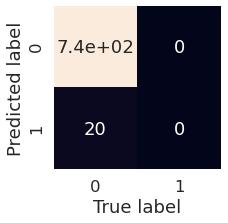

In [108]:
sns.set(font_scale=1.5)

def plot_confusion_mat(Y_test, Y_predict):
    """
    Plot a nice looking confusion matrix using seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(Y_test, Y_predict), 
                    annot = True,
                    cbar=False)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    
    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_confusion_mat(Y_test, Y_predict)    

In [109]:
print(classification_report(Y_test, Y_predict))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       737
           1       0.00      0.00      0.00        20

    accuracy                           0.97       757
   macro avg       0.49      0.50      0.49       757
weighted avg       0.95      0.97      0.96       757



/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

## RandomForest

In [110]:
model1 = RandomForestClassifier(n_estimators=10)

model1 = model1.fit(X_train, Y_train)

model1.score(X_test, Y_test)

0.9722589167767504

In [111]:
cross_val_score(model1, X_test, Y_test, cv=5)

array([0.97368421, 0.98684211, 0.97350993, 0.96688742, 0.97350993])

In [112]:
model1_predict = model1.predict(X_test)

In [113]:
confusion_matrix(Y_test, model1_predict)

array([[732,   5],
       [ 16,   4]])

In [114]:
print(classification_report(Y_test, model1_predict))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       737
           1       0.44      0.20      0.28        20

    accuracy                           0.97       757
   macro avg       0.71      0.60      0.63       757
weighted avg       0.96      0.97      0.97       757



# Resampling

## Oversampling (resample)

In [115]:
from sklearn.utils import resample

# Concatenate training data back togather
X = pd.concat([X_train, Y_train], axis=1)
X.head()

,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,precip_max,precip_min,precip_mean,Label
465,56,285.918640,280.606995,283.658966,98280.109375,96338.164062,97500.664062,26.568378,7.555609,14.245292,0.003355,0.000000,0.000357,1
131,75,289.366364,284.142731,287.503540,99405.812500,97664.804688,98402.476562,28.990921,17.775766,23.585161,0.001559,0.000063,0.000538,1
53,72,294.711884,285.905548,289.933289,99743.312500,97501.062500,98391.445312,34.449261,7.907701,19.024771,0.001193,0.000000,0.000114,1
71,71,288.957733,283.458435,286.556305,98901.867188,95774.070312,97516.218750,31.869045,7.716259,21.750496,0.004137,0.000000,0.000819,1
237,144,288.044159,280.554962,284.934662,99658.890625,96823.562500,97870.882812,32.300999,7.558475,17.803125,0.004036,0.000003,0.000398,1


In [116]:
# Seperate minority & majority classes
not_rain = X[X.Label==0]
rain = X[X.Label==1]

In [117]:
not_rain.head()

,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,precip_max,precip_min,precip_mean,Label
1942,73,292.462067,281.572937,287.170807,99783.492188,98513.039062,99476.390625,18.813868,9.368677,13.371630,0.000150,0.0,0.000029,0
2425,78,285.768097,276.614960,281.407257,100628.195312,98985.125000,99994.179688,17.986971,4.377110,11.784796,0.000626,0.0,0.000031,0
1428,105,288.321045,275.324188,281.969177,100288.507812,97487.937500,98995.125000,23.764713,6.303547,12.751715,0.001316,0.0,0.000093,0
1791,48,296.655121,288.196838,290.683624,98859.382812,98642.882812,98755.000000,40.051300,28.591917,33.592102,0.001255,0.0,0.000160,0
269,58,287.146637,281.214935,284.178040,99554.765625,98327.812500,98863.164062,24.875147,12.575388,17.005346,0.000796,0.0,0.000147,0


In [118]:
rain.head()

,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,precip_max,precip_min,precip_mean,Label
465,56,285.918640,280.606995,283.658966,98280.109375,96338.164062,97500.664062,26.568378,7.555609,14.245292,0.003355,0.000000,0.000357,1
131,75,289.366364,284.142731,287.503540,99405.812500,97664.804688,98402.476562,28.990921,17.775766,23.585161,0.001559,0.000063,0.000538,1
53,72,294.711884,285.905548,289.933289,99743.312500,97501.062500,98391.445312,34.449261,7.907701,19.024771,0.001193,0.000000,0.000114,1
71,71,288.957733,283.458435,286.556305,98901.867188,95774.070312,97516.218750,31.869045,7.716259,21.750496,0.004137,0.000000,0.000819,1
237,144,288.044159,280.554962,284.934662,99658.890625,96823.562500,97870.882812,32.300999,7.558475,17.803125,0.004036,0.000003,0.000398,1


In [119]:
# upsample minority 
rain_upsample = resample(rain,
                         replace=True, # sample with replacement
                         n_samples=len(not_rain), # match number in majority class
                         random_state=27)

In [120]:
rain_upsample.head()

,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,precip_max,precip_min,precip_mean,Label
278,10,284.957581,283.270325,283.960297,97802.562500,96858.390625,97203.796875,22.586397,19.917959,21.213264,0.001814,5.209335e-04,0.001086,1
738,73,291.207642,283.987885,287.334473,99650.757812,98198.835938,99170.328125,30.466537,10.201896,18.984324,0.000515,0.000000e+00,0.000054,1
336,59,283.785034,278.990570,281.551666,98625.992188,97269.437500,97847.914062,20.652874,8.270524,17.804363,0.002081,0.000000e+00,0.000798,1
108,48,292.210663,282.678650,288.992004,98662.062500,97497.789062,97978.109375,27.450247,8.533845,21.354918,0.001786,9.313226e-10,0.000266,1
484,110,294.477356,286.369080,289.492371,98935.429688,97219.710938,97752.132812,36.945503,22.619867,29.617113,0.003559,2.767358e-08,0.000527,1


In [121]:
# Combine majority and upsampling minority
upsample = pd.concat([not_rain, rain_upsample])
upsample.head()

,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,precip_max,precip_min,precip_mean,Label
1942,73,292.462067,281.572937,287.170807,99783.492188,98513.039062,99476.390625,18.813868,9.368677,13.371630,0.000150,0.0,0.000029,0
2425,78,285.768097,276.614960,281.407257,100628.195312,98985.125000,99994.179688,17.986971,4.377110,11.784796,0.000626,0.0,0.000031,0
1428,105,288.321045,275.324188,281.969177,100288.507812,97487.937500,98995.125000,23.764713,6.303547,12.751715,0.001316,0.0,0.000093,0
1791,48,296.655121,288.196838,290.683624,98859.382812,98642.882812,98755.000000,40.051300,28.591917,33.592102,0.001255,0.0,0.000160,0
269,58,287.146637,281.214935,284.178040,99554.765625,98327.812500,98863.164062,24.875147,12.575388,17.005346,0.000796,0.0,0.000147,0


In [134]:
upsample.Label.value_counts()

0    1721
1    1721
Name: Label, dtype: int64

### Logistic regression with balanced data

In [135]:
y_train = upsample.Label
x_train = upsample.drop('Label', axis=1)

In [136]:
# Model fitting
upsampled_model = LogisticRegression(solver='liblinear').fit(x_train, y_train)

In [137]:
upsampled_pred = upsampled_model.predict(X_test)
upsampled_pred

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,

In [138]:
print(classification_report(Y_test, upsampled_pred))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90       737
           1       0.09      0.60      0.15        20

    accuracy                           0.82       757
   macro avg       0.54      0.71      0.53       757
weighted avg       0.96      0.82      0.88       757



In [139]:
print(confusion_matrix(Y_test, upsampled_pred))

[[610 127]
 [  8  12]]


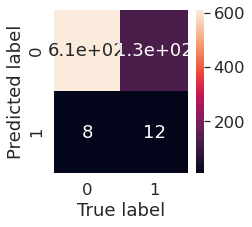

In [129]:
sns.set(font_scale=1.5)

def plot_confusion_mat(Y_test, Y_predict):
    """
    Plot a nice looking confusion matrix using seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(Y_test, Y_predict), 
                    annot = True,
                    cbar=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    
    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_confusion_mat(Y_test, upsampled_pred)   

In [140]:
upsampled_data = pd.DataFrame(upsampled_pred)
upsampled_data[0].value_counts()

0    618
1    139
Name: 0, dtype: int64

In [131]:
print(roc_auc_score(Y_test, upsampled_pred))

0.7138398914518318


### RandomForest

In [141]:
upsampled_model1 = RandomForestClassifier(class_weight={0:1, 1:10}).fit(x_train, y_train)

In [142]:
upsampled_model1_pred = upsampled_model1.predict(X_test)

In [143]:
accuracy_score(Y_test, upsampled_model1_pred)

0.9749009247027741

In [144]:
print(classification_report(Y_test, upsampled_model1_pred ))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       737
           1       0.57      0.20      0.30        20

    accuracy                           0.97       757
   macro avg       0.78      0.60      0.64       757
weighted avg       0.97      0.97      0.97       757



In [145]:
pd.DataFrame(confusion_matrix(Y_test, upsampled_model1_pred))

,0,1
0,734,3
1,16,4


### Decision Tree

In [146]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

clf = clf.fit(x_train, y_train)

clf_pred = clf.predict(X_test)

accuracy_score(Y_test, clf_pred)

0.964332892998679

In [147]:
print(confusion_matrix(Y_test, clf_pred))

[[721  16]
 [ 11   9]]


# Penalize Algorithm 

In [148]:
from sklearn.svm import SVC

# we can add class_weight='balanced' to add penalize mistake
svc_model = SVC(class_weight='balanced', probability=True)

In [149]:
svc_model = svc_model.fit(X_train, Y_train)

In [150]:
svc_pred = svc_model.predict(X_test)

In [153]:
print(confusion_matrix(Y_test, svc_pred))

[[  0 737]
 [  0  20]]


In [152]:
print(classification_report(Y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       737
           1       0.03      1.00      0.05        20

    accuracy                           0.03       757
   macro avg       0.01      0.50      0.03       757
weighted avg       0.00      0.03      0.00       757



/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

## penalize oversampling

In [154]:
svc_model1 = svc_model.fit(x_train, y_train)

In [155]:
svc_pred1 = svc_model1.predict(X_test)

In [156]:
print(confusion_matrix(Y_test, svc_pred1))

[[403 334]
 [  2  18]]


# Undersampling

In [157]:
# Downsampling majority
not_rain_downsampling = resample(not_rain,
                                 replace  = False, #sample without replacement
                                 n_samples = len(rain), # match minority n
                                 random_state=27)

In [71]:
#not_rain_downsampling

In [158]:
downsampled = pd.concat([not_rain_downsampling, rain])
downsampled

,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,precip_max,precip_min,precip_mean,Label
2322,56,287.753418,280.098267,284.388336,98670.734375,97314.140625,97744.093750,19.231724,7.531634,13.149152,0.000752,0.000000e+00,1.184316e-04,0
2565,137,288.215942,281.585114,284.608185,99612.882812,98172.617188,98797.468750,26.125088,8.694240,14.016080,0.000942,0.000000e+00,7.015865e-05,0
1836,48,291.130554,283.447937,286.765686,100242.687500,99168.601562,99855.132812,19.057726,9.686066,12.216554,0.000010,0.000000e+00,4.783712e-07,0
206,69,288.831146,281.731415,285.259430,99959.773438,98405.171875,99115.843750,24.789997,7.076274,13.898744,0.000803,1.322811e-07,1.323155e-04,0
1752,120,296.663391,285.622955,289.477539,99258.101562,98251.726562,98786.718750,31.590832,12.413706,21.615181,0.000784,0.000000e+00,8.361825e-05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,48,281.820343,277.277924,279.678772,99830.500000,97418.578125,98770.945312,15.690932,6.327796,9.994848,0.002269,3.638145e-06,4.252339e-04,1
773,78,298.440948,286.338928,292.088409,98827.835938,96703.046875,97609.562500,42.292416,12.697303,23.392792,0.001163,0.000000e+00,1.519499e-04,1
513,69,290.137238,286.059113,287.268402,99641.351562,97438.023438,98662.617188,43.090733,18.998308,27.514671,0.004345,2.262336e-05,7.788065e-04,1
350,123,292.514801,284.852478,288.811340,98967.773438,97620.421875,98376.039062,39.249565,8.577142,24.031067,0.002652,9.313226e-10,3.206509e-04,1


In [159]:
downsampled.Label.value_counts()

0    48
1    48
Name: Label, dtype: int64

In [160]:
y1_train = downsampled.Label
x1_train = downsampled.drop('Label', axis=1)

In [161]:
undersampled_model = LogisticRegression(solver='liblinear').fit(x1_train, y1_train)

In [162]:
undersampled_pred = undersampled_model.predict(X_test)

In [163]:
accuracy_score(Y_test, undersampled_pred)

0.8401585204755614

In [164]:
print(classification_report(Y_test, undersampled_pred))

              precision    recall  f1-score   support

           0       0.99      0.85      0.91       737
           1       0.10      0.60      0.17        20

    accuracy                           0.84       757
   macro avg       0.54      0.72      0.54       757
weighted avg       0.96      0.84      0.89       757



In [165]:
print(confusion_matrix(Y_test, undersampled_pred))

[[624 113]
 [  8  12]]


In [166]:
pd.DataFrame(confusion_matrix(Y_test, undersampled_pred))

,0,1
0,624,113
1,8,12


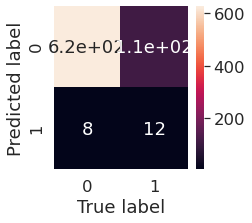

In [167]:
sns.set(font_scale=1.5)

def plot_confusion_mat(Y_test, Y_predict):
    """
    Plot a nice looking confusion matrix using seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(Y_test, Y_predict), 
                    annot = True,
                    cbar=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    
    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_confusion_mat(Y_test, undersampled_pred)  

## RandomForest

In [168]:
undersampled_model1 = RandomForestClassifier().fit(x1_train, y1_train)

y_pred_undersampled_model1 = undersampled_model1.predict(X_test)

print(confusion_matrix(Y_test, y_pred_undersampled_model1))

[[645  92]
 [  2  18]]


#  RandomForest with diff oversampling method

In [256]:
# Function to test diff oversampling methods with Randomforest 
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import BorderlineSMOTE
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV


np.random.seed(42)

upsample = {'RandomOverSampler': RandomOverSampler , 
            'SMOTETomek': SMOTETomek, 
            'SMOTEENN' :SMOTEENN, 
            'SMOTE' : SMOTE, 
            'ADASYN': ADASYN,
             'BorderlineSMOTE':BorderlineSMOTE }

grid = {'n_estimators' : [10, 100, 200, 500, 1000, 1200],
       'max_depth' : [None, 5, 10, 20, 30],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_split' : [2, 4, 6],
       'min_samples_leaf' : [1, 2, 4]}


def over_sample(x_train, y_train, x_test, y_test):
    # Looping methods
    for name, method in upsample.items():
        
        upsam = method()
        
        x_upsam, y_upsam = upsam.fit_resample(x_train, y_train)
        
        model = RandomForestClassifier().fit(x_upsam, y_upsam)
        
        # Setup RandomilzedSearchCV
#         rs_clf1 = RandomizedSearchCV(estimator = clf,
#                            param_distributions=grid,
#                            n_iter=20, # try 20 models total
#                            cv=5 # 5-fold cross-validation
#                              ).fit(x_upsam, y_upsam)

        
        y_pred = model.predict(x_test)
        
        
        print('confusion matrix for ' + str(name))
        print(metrics.confusion_matrix(y_test, y_pred))
        print(metrics.classification_report(y_test, y_pred))
#         print(metrics.classification_report(y_test, y_pred_ros))
#         print('Accuracy {}'.format(metrics.accuracy_score(y_test, y_pred_ros)) )
#         print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, y_pred_ros)))
        
        
over_sample(X_train, Y_train, X_test, Y_test)  

confusion matrix for RandomOverSampler
[[733   4]
 [ 15   5]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       737
           1       0.56      0.25      0.34        20

    accuracy                           0.97       757
   macro avg       0.77      0.62      0.67       757
weighted avg       0.97      0.97      0.97       757

confusion matrix for SMOTETomek
[[722  15]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       737
           1       0.42      0.55      0.48        20

    accuracy                           0.97       757
   macro avg       0.71      0.76      0.73       757
weighted avg       0.97      0.97      0.97       757

confusion matrix for SMOTEENN
[[713  24]
 [  5  15]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       737
           1       0.38      0.75      0.51        20

    accuracy

# XGSBoost with different upsample methods

In [257]:
# Function to test diff oversampling methods with Randomforest 
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import BorderlineSMOTE
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')



np.random.seed(42)

upsample = {'RandomOverSampler': RandomOverSampler , 
            'SMOTETomek': SMOTETomek, 
            'SMOTEENN' :SMOTEENN, 
            'SMOTE' : SMOTE, 
            'ADASYN': ADASYN,
             'BorderlineSMOTE':BorderlineSMOTE }

grid = {'n_estimators' : [10, 100, 200, 500, 1000, 1200],
       'max_depth' : [None, 5, 10, 20, 30],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_split' : [2, 4, 6],
       'min_samples_leaf' : [1, 2, 4]}


def over_sample(x_train, y_train, x_test, y_test):
    # Looping methods
    for name, method in upsample.items():
        
        upsam = method()
        
        x_upsam, y_upsam = upsam.fit_resample(x_train, y_train)
        
        model = XGBClassifier().fit(x_upsam, y_upsam)
        
        # Setup RandomilzedSearchCV
#         rs_clf1 = RandomizedSearchCV(estimator = clf,
#                            param_distributions=grid,
#                            n_iter=20, # try 20 models total
#                            cv=5 # 5-fold cross-validation
#                              ).fit(x_upsam, y_upsam)

        
        y_pred = model.predict(x_test)
        
        
        print('confusion matrix for ' + str(name))
        print(metrics.confusion_matrix(y_test, y_pred))
        print(metrics.classification_report(y_test, y_pred))
#         print('Accuracy {}'.format(metrics.accuracy_score(y_test, y_pred_ros)) )
#         print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, y_pred_ros)))
        
        
over_sample(X_train, Y_train, X_test, Y_test)  

[12:17:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix for RandomOverSampler
[[725  12]
 [ 15   5]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       737
           1       0.29      0.25      0.27        20

    accuracy                           0.96       757
   macro avg       0.64      0.62      0.63       757
weighted avg       0.96      0.96      0.96       757

[12:17:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to

# XGBoost Tuning

## Manual tuning

In [43]:
from imblearn.combine import SMOTETomek
from xgboost.sklearn import XGBClassifier
from sklearn import metrics

smk = SMOTETomek(random_state=42)
x1_upsam, y1_upsam = smk.fit_sample(X_train, Y_train)

model = XGBClassifier().fit(x1_upsam, y1_upsam)
        
y_pred = model.predict(X_test)
        
        
print('confusion matrix for ')
print(metrics.confusion_matrix(Y_test, y_pred))
print(metrics.classification_report(Y_test, y_pred))
        

/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:01:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix for 
[[719  18]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       737
           1       0.40      0.60      0.48        20

    accuracy                           0.97       757
   macro avg       0.69      0.79      0.73       757
weighted avg       0.97      0.97      0.97       757



In [304]:

smk = SMOTETomek(random_state=42)

x1_upsam, y1_upsam = smk.fit_resample(X_train, Y_train)

model = XGBClassifier(learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
       subsample=0.8,
      colsample_bytree=0.8,
      objective= 'binary:logistic',
      nthread=4,
      scale_pos_weight=1,
      seed=27).fit(x1_upsam, y1_upsam)
        
y_pred = model.predict(X_test)
        
        
print('confusion matrix for ' )
print(metrics.confusion_matrix(Y_test, y_pred))
print(metrics.classification_report(Y_test, y_pred))
#         print('Accuracy {}'.format(metrics.accuracy_score(y_test, y_pred_ros)) )
#         print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, y_pred_ros)))
        
    

[14:10:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix for 
[[721  16]
 [ 10  10]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       737
           1       0.38      0.50      0.43        20

    accuracy                           0.97       757
   macro avg       0.69      0.74      0.71       757
weighted avg       0.97      0.97      0.97       757



In [114]:
sm = SMOTETomek(random_state=42)
x1_upsam, y1_upsam = sm.fit_resample(X_train, Y_train)

## GridSearch (best result obtained)

In [115]:


param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)


model_grid = gsearch1.fit(x1_upsam,y1_upsam)
# gsearch1.best_params_, gsearch1.best_score_

grid_pred = model_grid.predict(X_test)

print(confusion_matrix(Y_test, grid_pred))
print(pd.DataFrame(confusion_matrix(Y_test, grid_pred)))
print(classification_report(Y_test, grid_pred))
print('Accuracy {}'.format(metrics.accuracy_score(Y_test, grid_pred)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(Y_test, grid_pred)))


/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:39:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[723  14]
 [  7  13]]
     0   1
0  723  14
1    7  13
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       737
           1       0.48      0.65      0.55        20

    accuracy                           0.97       757
   macro avg       0.74      0.82      0.77       757
weighted avg       0.98      0.97      0.97       757

Accuracy 0.9722589167767504
Area under the curve 0.8155020352781547


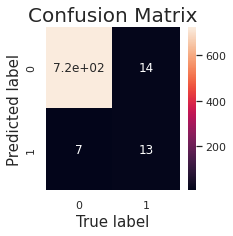

In [142]:
sns.set(font_scale=1.0)


def plot_conf_mat(y_test, y_preds):
    cf_mat = confusion_matrix(y_test, y_preds)
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(cf_mat,
                     annot=True,
                    
                   )
    plt.title('Confusion Matrix', size=20)
    plt.xlabel("True label", size=15)
    plt.ylabel("Predicted label", size=15)
    
    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_conf_mat(Y_test, grid_pred)


In [316]:
pd.DataFrame(confusion_matrix(Y_test, grid_pred))

,0,1
0,723,14
1,7,13


In [314]:
param_test2 = {
 'max_depth': [4,5,6],
 'min_child_weight':[4,5,6]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)

model_grid1 = gsearch2.fit(x1_upsam, y1_upsam)

model_grid1_predict = model_grid1.predict(X_test)

print(confusion_matrix(Y_test, model_grid1_predict))
print(classification_report(Y_test, model_grid1_predict))

[14:26:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[719  18]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       737
           1       0.42      0.65      0.51        20

    accuracy                           0.97       757
   macro avg       0.70      0.81      0.75       757
weighted avg       0.98      0.97      0.97       757



# SMOTE upsample with different ML algorithms

In [258]:
# Function to compute confusion matrices for different ML algorithms using SMOTE upsample 

from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from imblearn.over_sampling import SMOTE

np.random.seed(42)


Algorithms ={"XGBoost" : XGBClassifier,
          "Logisticregression " : LogisticRegression,
          "SVC" : SVC,
           "DecisionTree" : DecisionTreeClassifier,
           "RandomForest" : RandomForestClassifier}

def algorm(X_train, Y_train, X_test, Y_test):
    
    sm = SMOTE(random_state=42)
    x_upsam, y_upsam = sm.fit_sample(X_train, Y_train)

    for name, method in Algorithms.items():
        
        
        model = method()
        model1 = model.fit(x_upsam, y_upsam)
        y_pred = model1.predict(X_test)
        print('confusion matrix for ' + name)
        print(confusion_matrix(Y_test, y_pred))
        print(metrics.classification_report(Y_test, y_pred))
    


algorm(X_train, Y_train, X_test, Y_test)




[12:17:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix for XGBoost
[[720  17]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       737
           1       0.41      0.60      0.49        20

    accuracy                           0.97       757
   macro avg       0.70      0.79      0.74       757
weighted avg       0.97      0.97      0.97       757

confusion matrix for Logisticregression 
[[583 154]
 [  7  13]]
              precision    recall  f1-score   support

           0       0.99      0.79      0.88       737
           1       0.08      0.65      0.14        20

    accuracy                           0.79       757
   macro avg       0

# SMOTEBoost

In [189]:
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

from xgboost.sklearn import XGBClassifier

xgb_model = XGBClassifier()

print(xgb_model.get_xgb_params())



{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': None, 'gpu_id': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [190]:
xgb_model.fit(X_train, Y_train, eval_metric=['error'], eval_set=[(X_train, Y_train), (X_test, Y_test)])

[0]	validation_0-error:0.01470	validation_1-error:0.02510
[1]	validation_0-error:0.01300	validation_1-error:0.02906
[2]	validation_0-error:0.01074	validation_1-error:0.03170
[3]	validation_0-error:0.00791	validation_1-error:0.03302
[4]	validation_0-error:0.00735	validation_1-error:0.02642
[5]	validation_0-error:0.00622	validation_1-error:0.02774
[6]	validation_0-error:0.00509	validation_1-error:0.03038
[7]	validation_0-error:0.00565	validation_1-error:0.03038
[8]	validation_0-error:0.00509	validation_1-error:0.02906
[9]	validation_0-error:0.00509	validation_1-error:0.02906
[10]	validation_0-error:0.00452	validation_1-error:0.02774
[11]	validation_0-error:0.00396	validation_1-error:0.02906
[12]	validation_0-error:0.00339	validation_1-error:0.02510
[13]	validation_0-error:0.00283	validation_1-error:0.02642
[14]	validation_0-error:0.00283	validation_1-error:0.02774
[15]	validation_0-error:0.00283	validation_1-error:0.02510
[16]	validation_0-error:0.00283	validation_1-error:0.02510
[17]	va

/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-error:0.00226	validation_1-error:0.02510
[20]	validation_0-error:0.00226	validation_1-error:0.02642
[21]	validation_0-error:0.00170	validation_1-error:0.02642
[22]	validation_0-error:0.00113	validation_1-error:0.02510
[23]	validation_0-error:0.00056	validation_1-error:0.02642
[24]	validation_0-error:0.00056	validation_1-error:0.02642
[25]	validation_0-error:0.00056	validation_1-error:0.02642
[26]	validation_0-error:0.00056	validation_1-error:0.02642
[27]	validation_0-error:0.00056	validation_1-error:0.02642
[28]	validation_0-error:0.00056	validation_1-error:0.02510
[29]	validation_0-error:0.00056	validation_1-error:0.02510
[30]	validation_0-error:0.00056	validation_1-error:0.02510
[31]	validation_0-error:0.00056	validation_1-error:0.02642
[32]	validation_0-error:0.00056	validation_1-error:0.02642
[33]	validation_0-error:0.00056	validation_1-error:0.02642
[34]	validation_0-error:0.00056	validation_1-error:0.02642
[35]	validation_0-error:0.00056	validation_1-error:0.027

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [191]:
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

y_pred = xgb_model.predict(X_test) 
print('confusion matrix')
print(metrics.confusion_matrix(Y_test, y_pred))
print('classification report')
print(metrics.classification_report(Y_test, y_pred))
print('Accuracy')
print(metrics.accuracy_score(Y_test, y_pred))
print('Area under the curve {}'.format(metrics.roc_auc_score(Y_test, y_pred)))


confusion matrix
[[732   5]
 [ 16   4]]
classification report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       737
           1       0.44      0.20      0.28        20

    accuracy                           0.97       757
   macro avg       0.71      0.60      0.63       757
weighted avg       0.96      0.97      0.97       757

Accuracy
0.9722589167767504
Area under the curve 0.5966078697421981


## XGboost

In [192]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1769, 13), (757, 13), (1769,), (757,))

In [194]:
print(Y_train.value_counts())
print(Y_test.value_counts())

0    1721
1      48
Name: Label, dtype: int64
0    737
1     20
Name: Label, dtype: int64


In [226]:
# upsampling train data
from collections import Counter
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
x_upsam, y_upsam = sm.fit_sample(X_train, Y_train)


In [227]:
y_upsam.value_counts()

0    1721
1    1721
Name: Label, dtype: int64

In [228]:
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')


xgb_model = XGBClassifier()

print(xgb_model.get_xgb_params())

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': None, 'gpu_id': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [229]:
xgb_model.fit(x_upsam, y_upsam)

[11:05:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [231]:
y_pred_upsam = xgb_model.predict(X_test)

print('confusion matrix')
print(metrics.confusion_matrix(Y_test, y_pred_upsam))
print(metrics.classification_report(Y_test, y_pred_upsam))
print('Accuracy {}'.format(metrics.accuracy_score(Y_test, y_pred_upsam)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(Y_test, y_pred_upsam)))

confusion matrix
[[720  17]
 [  8  12]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       737
           1       0.41      0.60      0.49        20

    accuracy                           0.97       757
   macro avg       0.70      0.79      0.74       757
weighted avg       0.97      0.97      0.97       757

Accuracy 0.9669749009247027
Area under the curve 0.7884667571234736


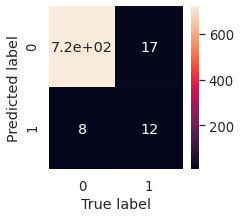

In [232]:
sns.set(font_scale=1.2)

def plot_confusion_mat(Y_test, Y_predict):
    """
    Plot a nice looking confusion matrix using seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(Y_test, Y_predict), 
                    annot = True,
                    cbar=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    
    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_confusion_mat(Y_test, y_pred_upsam) 

## LogisticRegression

In [233]:
# LogisticRegression
model1 = LogisticRegression(solver='liblinear').fit(x_upsam, y_upsam)

y_pred1  = model1.predict(X_test)

print('confusion matrix')
print(metrics.confusion_matrix(Y_test, y_pred1))
print(metrics.classification_report(Y_test, y_pred1))
print('Accuracy {}'.format(metrics.accuracy_score(Y_test, y_pred1)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(Y_test, y_pred1)))


confusion matrix
[[629 108]
 [  9  11]]
              precision    recall  f1-score   support

           0       0.99      0.85      0.91       737
           1       0.09      0.55      0.16        20

    accuracy                           0.85       757
   macro avg       0.54      0.70      0.54       757
weighted avg       0.96      0.85      0.89       757

Accuracy 0.845442536327609
Area under the curve 0.701729986431479


## SVC

In [234]:
# svc model
from sklearn.svm import SVC


svc_model = SVC()

In [235]:
model5 = svc_model.fit(x_upsam, y_upsam)

y_pred5 = model5.predict(X_test)

print('confusion matrix')
print(metrics.confusion_matrix(Y_test, y_pred5))
print(metrics.classification_report(Y_test, y_pred5))
print('Accuracy {}'.format(metrics.accuracy_score(Y_test, y_pred5)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(Y_test, y_pred5)))

confusion matrix
[[403 334]
 [  2  18]]
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       737
           1       0.05      0.90      0.10        20

    accuracy                           0.56       757
   macro avg       0.52      0.72      0.40       757
weighted avg       0.97      0.56      0.69       757

Accuracy 0.5561426684280053
Area under the curve 0.7234056987788331


## Decision Tree

In [236]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

np.random.seed(42)

dt = DecisionTreeClassifier()

model6 = dt.fit(x_upsam, y_upsam)

y_pred6 = model6.predict(X_test)

print('confusion matrix')
print(metrics.confusion_matrix(Y_test, y_pred6))
print(metrics.classification_report(Y_test, y_pred6))
print('Accuracy {}'.format(metrics.accuracy_score(Y_test, y_pred6)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(Y_test, y_pred6)))

confusion matrix
[[705  32]
 [ 11   9]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       737
           1       0.22      0.45      0.30        20

    accuracy                           0.94       757
   macro avg       0.60      0.70      0.63       757
weighted avg       0.96      0.94      0.95       757

Accuracy 0.9431968295904888
Area under the curve 0.7032903663500678


## RandomForest

In [238]:
# RandomForest
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

model2 = RandomForestClassifier().fit(x_upsam, y_upsam)

y_pred2 = model2.predict(X_test)

print('confusion matrix')
print(metrics.confusion_matrix(Y_test, y_pred2))
print(metrics.classification_report(Y_test, y_pred2))
print('Accuracy {}'.format(metrics.accuracy_score(Y_test, y_pred2)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(Y_test, y_pred2)))

confusion matrix
[[721  16]
 [ 10  10]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       737
           1       0.38      0.50      0.43        20

    accuracy                           0.97       757
   macro avg       0.69      0.74      0.71       757
weighted avg       0.97      0.97      0.97       757

Accuracy 0.9656538969616909
Area under the curve 0.7391451831750339


In [248]:
model2.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Hyperparameter tunning (RandomForest)

#### Randomizedsearchcv

In [249]:
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(42)

# Hyperparameter grid RandomizedSearchCV will search over
grid = {'n_estimators' : [10, 100, 200, 500, 1000, 1200],
       'max_depth' : [None, 5, 10, 20, 30],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_split' : [2, 4, 6],
       'min_samples_leaf' : [1, 2, 4]}

clf = RandomForestClassifier(n_jobs=1)

# Setup RandomilzedSearchCV
rs_clf = RandomizedSearchCV(estimator = clf,
                           param_distributions=grid,
                           n_iter=2, # try 20 models total
                           cv=2 # 5-fold cross-validation
                             ) 


# Fit the RandomizedSearchCV version of clf
rs_clf.fit(x_upsam, y_upsam)

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=1), n_iter=2,
                   param_distributions={'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [10, 100, 200, 500,
                                                         1000, 1200]})

In [250]:
# Make predictions with the best hyperparamters
rs_y_pred = rs_clf.predict(X_test)

print('confusion matrix')
print(metrics.confusion_matrix(Y_test, rs_y_pred))
print(metrics.classification_report(Y_test, rs_y_pred))
print('Accuracy {}'.format(metrics.accuracy_score(Y_test, rs_y_pred)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(Y_test, rs_y_pred)))

confusion matrix
[[718  19]
 [ 10  10]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       737
           1       0.34      0.50      0.41        20

    accuracy                           0.96       757
   macro avg       0.67      0.74      0.69       757
weighted avg       0.97      0.96      0.97       757

Accuracy 0.9616908850726552
Area under the curve 0.7371099050203529


In [51]:
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(42)

# Hyperparameter grid RandomizedSearchCV will search over
grid = {'n_estimators' : [10, 100, 200, 500, 1000, 1200],
       'max_depth' : [None, 5, 10, 20, 30],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_split' : [2, 4, 6],
       'min_samples_leaf' : [1, 2, 4]}

clf = RandomForestClassifier(n_jobs=1)

# Setup RandomilzedSearchCV
rs_clf1 = RandomizedSearchCV(estimator = clf,
                           param_distributions=grid,
                           n_iter=20, # try 20 models total
                           cv=5 # 5-fold cross-validation
                             ) 


# Fit the RandomizedSearchCV version of clf
rs_clf1.fit(x_upsam, y_upsam)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=1), n_iter=20,
                   param_distributions={'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [10, 100, 200, 500,
                                                         1000, 1200]})

In [52]:
rs_clf1.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None}

In [53]:
# Make predictions with the best hyperparamters
rs_y_pred1 = rs_clf1.predict(x_test)

print('confusion matrix')
print(metrics.confusion_matrix(y_test, rs_y_pred1))
print(metrics.classification_report(y_test, rs_y_pred1))
print('Accuracy {}'.format(metrics.accuracy_score(y_test, rs_y_pred1)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, rs_y_pred1)))

confusion matrix
[[1723   34]
 [  16    5]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1757
         1.0       0.13      0.24      0.17        21

    accuracy                           0.97      1778
   macro avg       0.56      0.61      0.58      1778
weighted avg       0.98      0.97      0.98      1778

Accuracy 0.9718785151856018
Area under the curve 0.6093720356668564


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(42)

# Hyperparameter grid RandomizedSearchCV will search over
grid1 = {'n_estimators' : [10, 100, 200, 500, 1000, 1200, 1500, 2000, 2200, 2500],
       'max_depth' : [None, 5, 10, 20, 30, 50, 70, 100],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_split' : [2, 4, 6, 8, 10],
       'min_samples_leaf' : [1, 2, 4],
       'bootstrap' : [True, False]}

clf = RandomForestClassifier(n_jobs=1)

# Setup RandomilzedSearchCV
rs_clf2 = RandomizedSearchCV(estimator = clf,
                           param_distributions=grid1,
                           n_iter=20, # try 20 models total
                           cv=5 # 5-fold cross-validation
                             ) 


# Fit the RandomizedSearchCV version of clf
rs_clf2.fit(x_upsam, y_upsam)

In [ ]:
rs_clf2.best_params_

In [ ]:
# Make predictions with the best hyperparamters
rs_y_pred2 = rs_clf2.predict(x_test)

print('confusion matrix')
print(metrics.confusion_matrix(y_test, rs_y_pred2))
print(metrics.classification_report(y_test, rs_y_pred2))
print('Accuracy {}'.format(metrics.accuracy_score(y_test, rs_y_pred2)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, rs_y_pred2)))

#### Gridsearchcv

In [31]:
grid_naive_up = GridSearchCV(rf, param_grid=params, cv=kf, scoring='recall').fit(x_train_up, y_train_up)

grid_naive_up.best_score_

0.9940787998355697

In [37]:
# GridSearch
from sklearn.model_selection import GridSearchCV

grid1 = {'n_estimators' : [10, 100, 200, 500, 1000, 1200, 1500, 2000, 2200, 2500],
       'max_depth' : [None, 5, 10, 20, 30, 50, 70, 100],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_split' : [2, 4, 6, 8, 10],
       'min_samples_leaf' : [1, 2, 4],
       'bootstrap' : [True, False]}

clf = RandomForestClassifier(n_jobs=1)

gd_clf = GridSearchCV(estimator = clf,
                     param_grid = grid1,
                     cv=2)

gd_clf.fit(x_upsam, y_upsam)


KeyboardInterrupt: 

In [ ]:
gd_clf.best_paras_

In [ ]:
# Make predictions with the best hyperparamters
gd_y_pred = gd_clf.predict(x_test)

print('confusion matrix')
print(metrics.confusion_matrix(y_test, gd_y_pred))
print(metrics.classification_report(y_test, gd_y_pred))
print('Accuracy {}'.format(metrics.accuracy_score(y_test, gd_y_pred)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, gd_y_pred)))

# Cross validation

In [211]:
# To divide data into train, valild and test
np.random.seed(42)

#Split the data into train, validation & test sets
#train_split = round(0.5 * len(train_data)) # 50% of train data
valid_split = round(0.15*len(test_data)) # 15% of test data

#X_train, Y_train = X[:train_split], Y[:train_split]
x_valid, y_valid = X_test[:valid_split], Y_test[:valid_split]
x_test, y_test = X_test[valid_split:], Y_test[valid_split:]

# Fit the model


In [213]:
# To get the same split each time
kf = KFold(n_splits=5, shuffle=False)

In [214]:
#x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42)

rf = RandomForestClassifier(random_state=42)

cross_val_score(rf, X_train, Y_train, cv=kf, scoring='recall')

array([0., 0., 0., 0., 0.])

In [215]:
params = {'n_estimators' : [500, 1000, 2000],
         #'max_dept' : [4, 65, 10, 12],
         'random_state' :[42]}

grid1 = {'n_estimators' : [10, 100, 200, 500, 1000, 1200, 1500, 2000, 2200, 2500],
       'max_depth' : [None, 5, 10, 20, 30, 50, 70, 100],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_split' : [2, 4, 6, 8, 10],
       'min_samples_leaf' : [1, 2, 4],
       'bootstrap' : [True, False]}

grid_no_up = GridSearchCV(rf, param_grid=params, cv=kf, scoring='recall').fit(X_train, Y_train)

In [216]:
grid_no_up.best_score_

0.0

In [217]:
y_pred = grid_no_up.predict(x_test)
confusion_matrix(y_test, y_pred)


array([[642,   1],
       [  0,   0]])

## oversample

In [220]:
x_train_up, y_train_up = SMOTE(random_state=42).fit_sample(X_train, Y_train)

In [221]:


grid_naive_up = GridSearchCV(rf, param_grid=params, cv=kf, scoring='recall').fit(x_train_up, y_train_up)

grid_naive_up.best_score_

0.7818896327617259

In [222]:
y_pred_up = grid_naive_up.predict(x_test)

print(confusion_matrix(y_test, y_pred_up))
print(classification_report(y_test, y_pred_up))

[[629  14]
 [  0   0]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       643
           1       0.00      0.00      0.00         0

    accuracy                           0.98       643
   macro avg       0.50      0.49      0.49       643
weighted avg       1.00      0.98      0.99       643



In [223]:
y_train_up.value_counts()

0    1721
1    1721
Name: Label, dtype: int64

In [224]:
y_train.value_counts()

0    1721
1    1721
Name: Label, dtype: int64